ReadMe:

Question 1 is answered in part 1.

Question 2 is answered in part 2. (unfinished)

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
%cd /content/drive/My\ Drive/Winter\ 2022/CME241

Mounted at /content/drive
/content/drive/My Drive/Winter 2022/CME241


In [2]:
from rl.distribution import *
from rl.markov_process import *
from rl.markov_decision_process import *
from rl.policy import *

import matplotlib.pyplot as plt

In [158]:
from rl.chapter9.order_book import *

#1. Order Book Dynamics

First, we will try to investigate on how the class OrderBook works. 

Let us consider a simple example, where the orderbook is small. Says the orderbook contains 
1. descending_bids = [(4.00, 2), (3.70, 3), (2.10, 1)]
2. ascending_asks = [(4.05, 4), (4.3, 7)]

In [4]:
descending_bids = [DollarsAndShares(dollars=4.00, shares=2), DollarsAndShares(dollars=3.70, shares=3), DollarsAndShares(dollars=2.10, shares=1)]
ascending_asks = [DollarsAndShares(dollars=4.05, shares=4), DollarsAndShares(dollars=4.30, shares=7)]

From the bids and asks, we can create an orderbook

In [5]:
Book = OrderBook(descending_bids=descending_bids, ascending_asks=ascending_asks)

Bid Price:  4.0
Ask Price:  4.05
Mid Price:  4.025
Spread:  0.04999999999999982
Depth:  2.1999999999999997


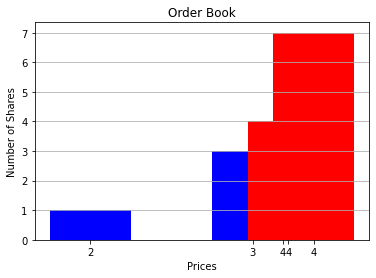

In [6]:
print('Bid Price: ', Book.bid_price())
print('Ask Price: ', Book.ask_price())
print('Mid Price: ', Book.mid_price())
print('Spread: ', Book.bid_ask_spread())
print('Depth: ', Book.market_depth())

Book.display_order_book()

If we try to push a sell limit order (ask) for a price higher than the (highest) bids, the transaction will not occur and the sell limit order will be added into the ascending_asks in the orderbook.

In [7]:
Book.descending_bids

[DollarsAndShares(dollars=4.0, shares=2),
 DollarsAndShares(dollars=3.7, shares=3),
 DollarsAndShares(dollars=2.1, shares=1)]

In [8]:
Book.sell_limit_order(price = 8.00, shares=3)[0]

DollarsAndShares(dollars=0.0, shares=0)

If we push a sell limit order cheaper than the bids, the bids will be eaten until the best bid is lower than the sell limit order price. The price that the seller will get is the price in the limit order book.

In [9]:
Book.sell_limit_order(price = 3.00, shares=8)[0]

DollarsAndShares(dollars=19.1, shares=5)

Next, we try to use market order.

In [10]:
Book.sell_market_order(shares=8)[0]

DollarsAndShares(dollars=21.200000000000003, shares=6)

We have also seen that if we want to buy more than the supply exists, we can buy only upto the total supply.

##Simple Model

###  Zero-Intelligence Model (2002)

We first consider a simple model of the double auction seen in the limited order book. We will first consider the case when the inputing limit orders and market orders are iid. suggested by the paper "Statistical Theory of the Continuous Double Auction" Smith et al., 2002. In the paper, the idea of zero-intelligence is assumed, allowing the orders to be independent. In this framework, the market orders are poissons. The cancellation orders are small Bernouli random variables (when the random variable is 1, removes the whole order.) The limit order is then uniform (in price) and poisson in quantity. The boundary of the buy limit order will be the highest bid price and $+\infty$. The boundary of the sell limit order will be $-\infty$ and the lowest ask price.

(Another note is that the paper use log price instead of price, so the price of $-\infty$ is indeed zero)



###Our Implementation

In this case, we do not consider cancellation.

Note that in the paper, they let the distribution of the limit order to be unbounded, and consider the price far from the midprice to be stationary (birth by limit order and death by cancellation.). THus, we will then want to change the limit order to be bounded (otherwise the prices farther from the midprice will stay there forever).

Thus, we can assume that the sell market order is poisson with a parameter $\mu$, and the buy market order is poisson with a parameter $\mu$

For the buy limit order, we therefore, limit the let the price be uniformly at random from [bid_price, high] and select N prices at each timesteps. 

For the sell limit order, we therefore, limit the let the price be uniformly at random from [low, ask_price] and select N prices at each timesteps. 

In [111]:
#Low price, high price
low_price: float = 20.0
high_price: float = 150.0

#Market order parameters(Note that we use different notation from the paper)
sell_market_order_rate: float = 13.8
buy_market_order_rate: float = 13.8

#Limit order parameters
sell_limit_N: int = 6
buy_limit_N: int = 6
sell_limit_order_rate: float = 2.9
buy_limit_order_rate: float = 2.9

Initilaize Book.

In [112]:
descending_bids = []
ascending_asks = []

Book = OrderBook(descending_bids=descending_bids, ascending_asks=ascending_asks)

We will submit market orders first.

In [113]:
#Buy market order
receipt, Book = Book.buy_market_order(np.random.poisson(buy_market_order_rate))

#Sell market order
receipt, Book = Book.sell_market_order(np.random.poisson(sell_market_order_rate))

Afterwards, we will submit limit orders.

In [114]:
#Sell limit order

#First, we have to find the ask price.
#Note that if we start with empty book, the ask price will not exist.
#Thus, we will use high_price instead.
if len(Book.ascending_asks) == 0:
  ask_price = high_price
else:
  ask_price = Book.ask_price()

#Find prices and qunatities
sell_price = np.random.uniform(low=low_price, high=ask_price, size=sell_limit_N)
sell_quantity = np.random.poisson(lam=sell_limit_order_rate, size=sell_limit_N)

#Submit limit sell orders
for i in range(sell_limit_N):
  receipt, Book = Book.sell_limit_order(sell_price[i], sell_quantity[i])

In [115]:
#Buy limit order

#First, we have to find the bid price.
#Note that if we start with empty book, the ask price will not exist.
#Thus, we will use high_price instead.
if len(Book.descending_bids) == 0:
  bid_price = low_price
else:
  bid_price = Book.bid_price()

#Find prices and qunatities
buy_price = np.random.uniform(low=bid_price, high=high_price, size=buy_limit_N)
buy_quantity = np.random.poisson(lam=buy_limit_order_rate, size=buy_limit_N)

#Submit limit buy orders
for i in range(buy_limit_N):
  receipt, Book = Book.buy_limit_order(buy_price[i], buy_quantity[i])

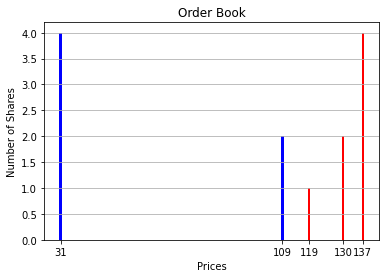

In [116]:
Book.display_order_book()

We can then find the next state.

In [117]:
receipt, Book = Book.buy_market_order(np.random.poisson(buy_market_order_rate))
receipt, Book = Book.sell_market_order(np.random.poisson(sell_market_order_rate))
if len(Book.ascending_asks) == 0:
  ask_price = high_price
else:
  ask_price = Book.ask_price()
sell_price = np.random.uniform(low=low_price, high=ask_price, size=sell_limit_N)
sell_quantity = np.random.poisson(lam=sell_limit_order_rate, size=sell_limit_N)
for i in range(sell_limit_N):
  receipt, Book = Book.sell_limit_order(sell_price[i], sell_quantity[i])
if len(Book.descending_bids) == 0:
  bid_price = low_price
else:
  bid_price = Book.bid_price()
buy_price = np.random.uniform(low=bid_price, high=high_price, size=buy_limit_N)
buy_quantity = np.random.poisson(lam=buy_limit_order_rate, size=buy_limit_N)
for i in range(buy_limit_N):
  receipt, Book = Book.buy_limit_order(buy_price[i], buy_quantity[i])

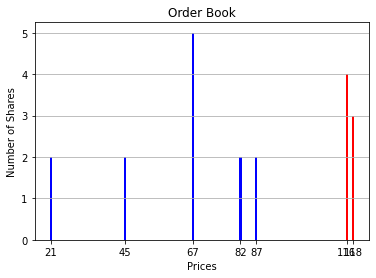

In [118]:
Book.display_order_book()

### Transition

From this point, we can create the transition parameterized by
1. low_price
2. high_price
3. sell_market_order_rate
4. buy_market_order_rate
5. sell_limit_N
6. buy_limit_N
7. sell_limit_order_rate
8. buy_limit_order_rate


In [128]:
@dataclass(frozen=True)
class transition_parameters:
  #Low price, high price
  low_price: float = 20.0
  high_price: float = 150.0

  #Market order parameters(Note that we use different notation from the paper)
  sell_market_order_rate: float = 13.8
  buy_market_order_rate: float = 13.8

  #Limit order parameters
  sell_limit_N: int = 6
  buy_limit_N: int = 6
  sell_limit_order_rate: float = 2.9
  buy_limit_order_rate: float = 2.9

In [143]:
def orderbook_transition(Book: OrderBook, parameters: transition_parameters) -> OrderBook:
    receipt, Book = Book.buy_market_order(np.random.poisson(parameters.buy_market_order_rate))
    receipt, Book = Book.sell_market_order(np.random.poisson(parameters.sell_market_order_rate))
    if len(Book.ascending_asks) == 0:
      ask_price = parameters.high_price
    else:
      ask_price = Book.ask_price()
    sell_price = np.random.uniform(low=parameters.low_price, high=ask_price, size=parameters.sell_limit_N)
    sell_quantity = np.random.poisson(lam=parameters.sell_limit_order_rate, size=parameters.sell_limit_N)
    for i in range(parameters.sell_limit_N):
      receipt, Book = Book.sell_limit_order(sell_price[i], sell_quantity[i])
    if len(Book.descending_bids) == 0:
      bid_price = parameters.low_price
    else:
      bid_price = Book.bid_price()
    buy_price = np.random.uniform(low=bid_price, high=parameters.high_price, size=parameters.buy_limit_N)
    buy_quantity = np.random.poisson(lam=parameters.buy_limit_order_rate, size=parameters.buy_limit_N)
    for i in range(parameters.buy_limit_N):
      receipt, Book = Book.buy_limit_order(buy_price[i], buy_quantity[i])
    return Book

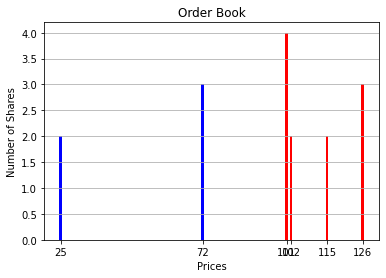

In [153]:
parameters = transition_parameters()
Book = orderbook_transition(Book, parameters)
Book.display_order_book()

###Stationary(?)

The paper shows that the fact that we limit the boundary of the limit sell and limit buy orders to not be exercised immediately, the coupling between the limit order process and the market order process will lead to stationary spread. (One can think of the market porcess to widen the spread and the limit procerss to reduce the spread).

Since we have modified the model from the proposed model in the paper, we then want to test (as a sanity check) to see whether the characteristic is still likely to be held by simulation.

In this one, we will set the number of limit order to be 1 per time step.

In [154]:
transition_parameters(sell_limit_N=1, buy_limit_N=1, sell_market_order_rate=1.3, buy_market_order_rate=1.3, sell_limit_order_rate=1.3, buy_limit_order_rate=1.3)

transition_parameters(low_price=20.0, high_price=150.0, sell_market_order_rate=1.3, buy_market_order_rate=1.3, sell_limit_N=1, buy_limit_N=1, sell_limit_order_rate=1.3, buy_limit_order_rate=1.3)

In [190]:
#Inintialize Empty Book
descending_bids=[]
ascending_asks=[]
Book = OrderBook(descending_bids=descending_bids, ascending_asks=ascending_asks)

Spreads = []

num_steps = 80000
for i in range(num_steps):
  Book = orderbook_transition(Book, parameters)
  if len(Book.ascending_asks)>0 and len(Book.descending_bids)>0:
    spread = Book.bid_ask_spread()
    Spreads.append(spread)

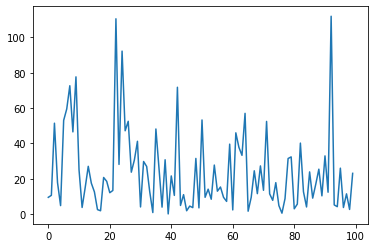

In [191]:
plt.plot(Spreads[0:100])
plt.show()

To evaluate whether the process is likely to be stationary or not we will try to evaluate the moving average and moving variance

In [192]:
window_size = 3000

#Moving Average
ma = np.convolve(Spreads, np.ones(window_size), 'valid') / window_size

#Moving STD
mstd = np.sqrt(np.convolve(np.square(Spreads), np.ones(window_size), 'valid') / window_size - np.square(ma))

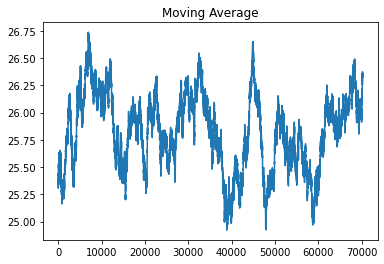

In [193]:
plt.plot(ma)
plt.title('Moving Average')
plt.show()

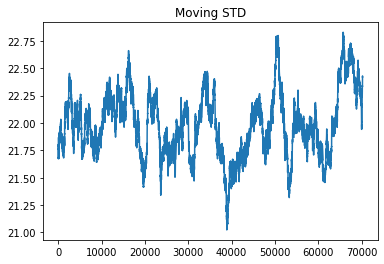

In [194]:
plt.plot(mstd)
plt.title('Moving STD')
plt.show()

This may not be able to confirm the stationarity, but we, at least, get that it is possible to be stationary. (At least, the moving average does not explode to infinity.)

#2. LPT Price Impact

In the paper "Statistical Theory of the Continuous Double Auction" Smith et al., 2002, we used as a reference above. The price impact (in the logarithmic scale) is concave. The emprical data also suggests the concavity in the log(impact price). 